In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.backends.cudnn as cudnn
from models import Encoder, DecoderWithRNN, DecoderWithAttention
from datasets import *
from solver import *
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

In [2]:
cfg = {
    # Data parameters
    'data_folder' : './data/coco2014/',  # folder with data files saved by create_input_files.py
    'data_name' : 'coco_5_cap_per_img_5_min_word_freq',  # base name shared by data files
    # Model parameters
    'embed_dim' : 512,  # dimension of word embeddings
    'attention_dim' : 512,  # dimension of attention linear layers
    'decoder_dim' : 512,  # dimension of decoder RNN
    'dropout' : 0.5,
    'device' : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),  # sets device for model and PyTorch tensors
    # Training parameters
    'start_epoch' : 0,
    'epochs' : 15,  # number of epochs to train for (if early stopping is not triggered)
    'epochs_since_improvement' : 0,  # keeps track of number of epochs since there's been an improvement in validation BLEU
    'batch_size' : 16,
    'workers' : 2,  # for data-loading; right now, only 1 works with h5py
    'encoder_lr' : 1e-4,  # learning rate for encoder if fine-tuning
    'decoder_lr' : 4e-4,  # learning rate for decoder
    'grad_clip' : 8.,  # clip gradients at an absolute value of
    'alpha_c' : 1.,  # regularization parameter for 'doubly stochastic attention', as in the paper
    'best_bleu4' : 0.,  # BLEU-4 score right now
    'print_freq' : 200,  # print training/validation stats every __ batches
    'fine_tune_encoder' : True,  # fine-tune encoder or not
    'checkpoint' : None,  # path to checkpoint, None if none
    'attention' : True, # train decoder with attention or not
}
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

In [3]:
word_map_file = os.path.join(cfg['data_folder'], 'WORDMAP_' + cfg['data_name'] + '.json')
with open(word_map_file, 'r') as j:
    word_map = json.load(j)
cfg['vocab_size'] = len(word_map)

## 1. Code Implementation

Two decoder architectures are implemented in this experiment. We compared and contrasted on how they behave on the same dataset under the same task. In this section, we will shortly introduce each structure and the associated code. The code implemented is inspired by: https://gitcode.com/sgrvinod/a-pytorch-tutorial-to-image-captioning/overview and https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/tree/master . This reference is also addressed at the head of the mdoel.py file.  

### 1.1 Decoder with RNN 
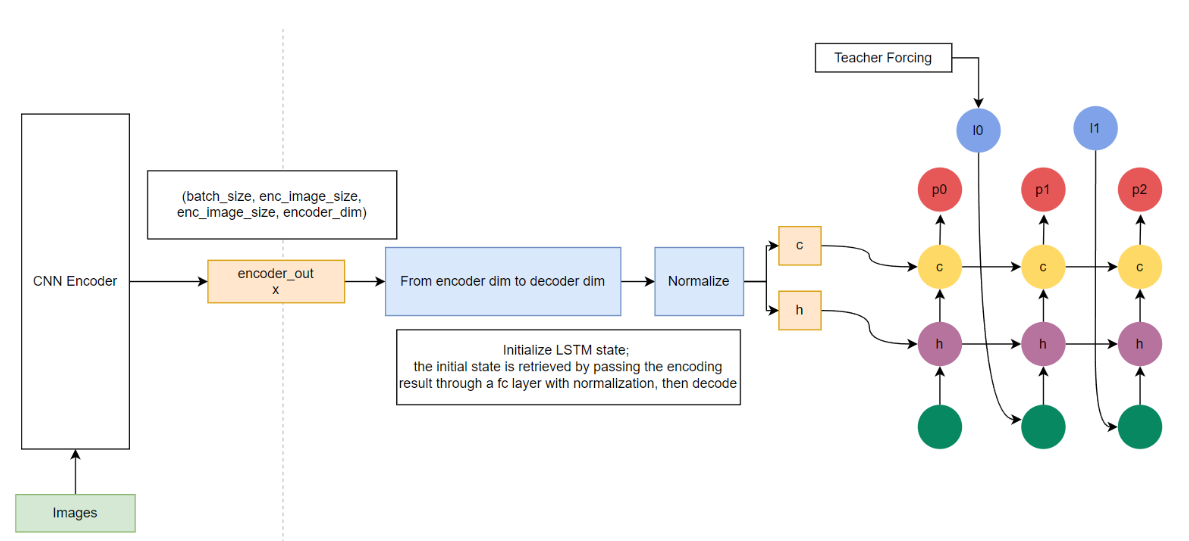
Once the images have finished embedding, the result will go through a full connect layer with normalization and a decode to initialize the LSTM state, that is, hidden state and cell(memory) state. The predicted probability is calculated by a FC layer and softmax. To move from timestep t to t+1, we use the correct label word rather than the prediction from the last step as the input. This mechanism is known as “teacher forcing” mentioned above. By using this technique, the model can generally converge faster and reduce error propagation, which refers to mistakes made early in the sequence that can compound and affect the quality of later predictions.  
There is in addition a dropout layer before feeding the hidden state into the FC layer for generating probabilities. This dropout layer can be removed, that is, we could choose whether to embed any dropout mechanism. Since we already have “dropout” in model configuration, we will use this mechanism in the model.

### 1.2 Decoder with RNN and Attention
This ability of self-selection is called attention. It is a simulation of a complex cognitive ability that human beings possess. The attention mechanism allows the neural network to have the ability to focus on its subset of inputs to select specific features.  
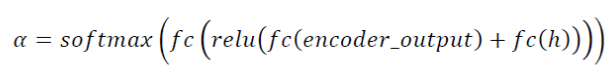  
The ‘encoder_attention’ and ‘decoder_attention’ are the two FC layers in the formula above. With these two layers, one could transform the tensor from the encoder output and the decoder output to the dimension of attention. Except alpha, the attention weight, the calculation also generates a “z”, a dynamic representation of relevant part of the image input at timestep t.   

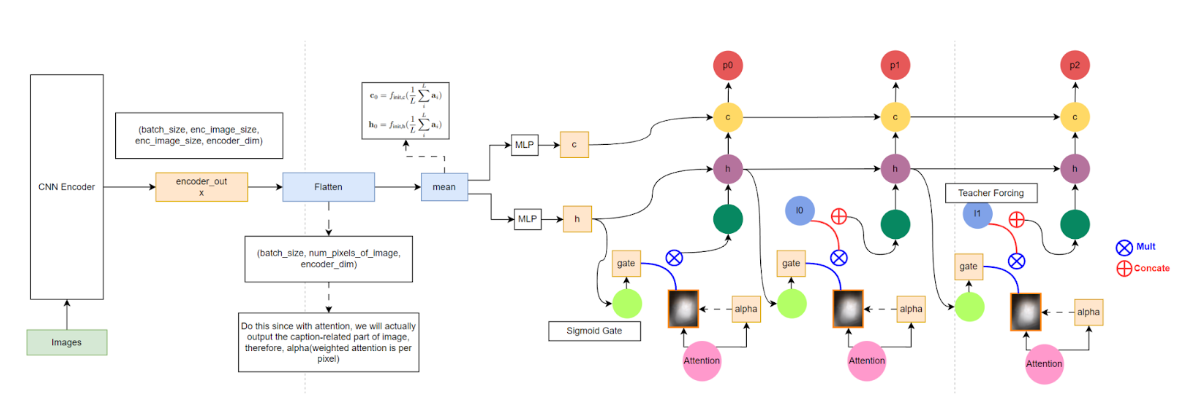
  



## 2. Parameter Tuning

The overall dataset has a large amount of data point. In order to iterate fast to find a proper combination of parameters and model structures. 
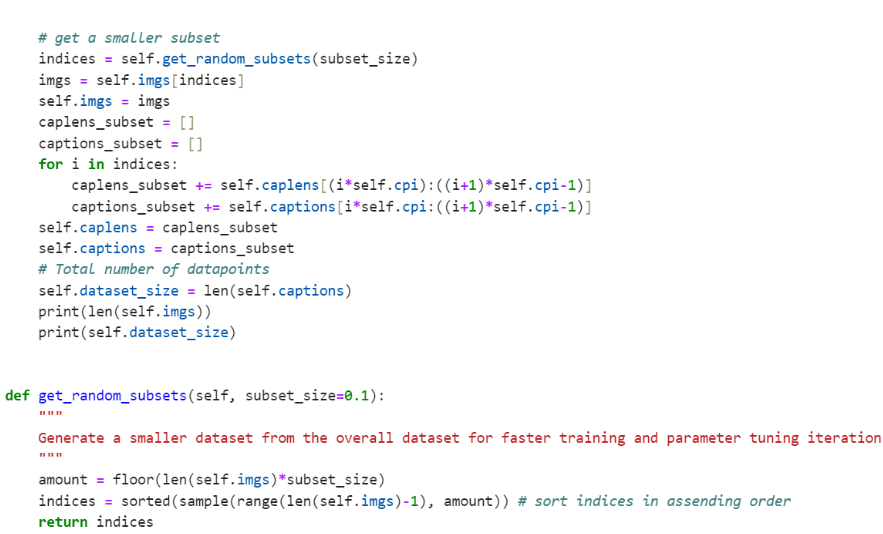   
Above is the code to generate a much smaller subset from all data randomly. The subset size suggests how much percentage of data we want to have in the subset. For tuning parameters, we take 20% of the data.   

### 2.1 Performance Evaluation
There are in total three parameters we used in this task to measure a model performance, loss, accuracy, and BLEU.   

BLEU, or the Bilingual Evaluation Understudy, is a score for comparing a candidate translation of text to one or more reference translations. Although developed for translation, it can be used to evaluate text generated for a suite of natural language processing task]  
.
The reason we are not only using accuracy scores is that, "accuracy" is the percentage of correctly predicted tokens, "accuracy per sequence" is the percentage of correctly predicted sequences (sentences), i.e. sequences where all tokens are correctly predicted. On the other hand, BLEU is a more document-level metric. It measures not only on how much the model gets correct, but also grammatical quality 
. 
BLEU scores fall between 0-100. When a BLEU score is lower than 20, the prediction is almost useless. When the score is between 20 to 30, the description is good but has significant grammatical errors. When it goes above 30, we can generally say the generated text is good enough. Once the score is over 60, the quality is often better than hu1  
3].
In this section, since we only use a small dataset, it is under prediction that the BLEU scores and accuracy metrics may not be ideal. Therefore, the goal is to get the hyperparameter combination that provides an ideal learning trend on the mod

### 2.2 Gradient Clipping   
eAdam optimization algorithm is used in the training process. It is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing.

Gradient clipping is also introduced to avoid exploding gradients, especially in back propagation. It is a method where the error derivative is changed or clipped to a threshold during backward propagation through the network, and using the clipped gradients to update the weights. By rescaling the error derivative, the updates to the weights will also be rescaled, dramatically decreasing the likelihood of an overflow or underflow.   

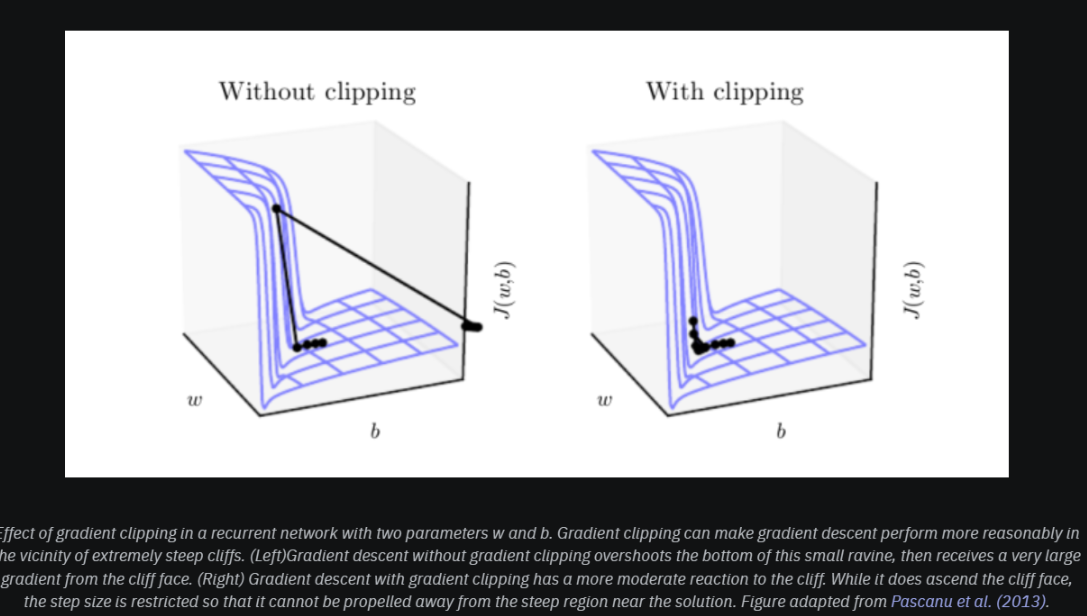
l. 



### 2.3 Batch Size

ref: https://www.baeldung.com/cs/learning-rate-batch-size#:~:text=The%20batch%20size%20affects%20some,and%20a%20good%20initial%20choice.   

The batch size affects some indicators such as overall training time, training time per epoch, quality of the model, and similar. Usually, we chose the batch size as a power of two, in the range between 16 and 512. But generally, the size of 32 is a rule of thumb and a good initial choice.    

In this section, we will test batch size: [8, 16, 32, 64].

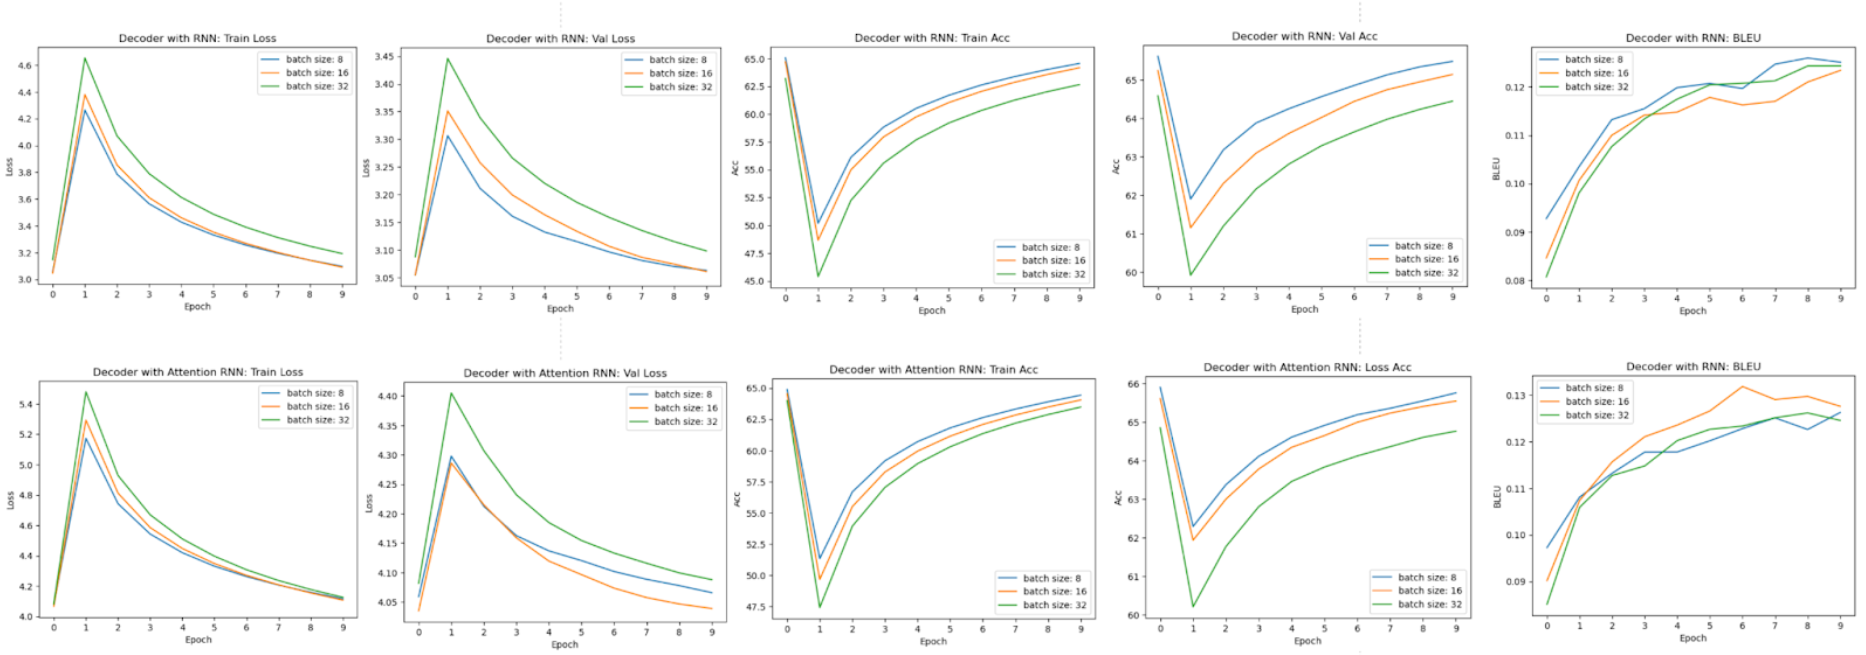  

<b>Observations:</b>  
1. The accuracy score of a model has negative correlation with the loss. The lower the loss gets, the higher the accuracy will reach.
2. With different batch sizes, the loss first increases drastically from epoch 1 to 2, then follows a downward trend. One potential cause of this event is the annealing on the learning rate, or the gradient clipping has affected the convergence.
3. <i>Decoder with RNN</i>:
   *  The smaller the batch size is, the faster the model converges. It allows the model to start learning before seeing a comparatively large amount of data, and also updates the model in a more frequent manner than with a larger dataset.
   *  Batch size 32 has the highest loss and lowest accuracy on both the training set and the validation set.
   *  Batch size 8 has the best accuracy score and BLEU metrics. Batch 32 has the second best BLEU score. Loss curve and accuracy curve with batch size 16 starts to approximate batch 8’s after epoch 6, but has a comparatively low BLEU score. This suggests that a. Accuracy and BLEU do not necessarily correlate; b. Within a certain range, the batch size provides a more accurate direction of decline in training loss, while reaching to a certain degree, the direction of decline is not changing.
4. <i>Decoder with RNN and Attention</i>:
   * Unlike pure RNN, batch size 16 has the best performance among the three values we tested with Attention RNN.
   * Batch size 32 has the worst performance with the highest loss and the lowest accuracy. Its BLEU score is close to batch size 8, and gets better than batch size 8 after epoch 4. This is potentially caused as the model starts to learn more features that can be generalized to the unknown data, rather than picking up those that could result in overfitting.  
5. The highest BLEU score is at around 0.12-0.13, which indicates that the captions are not of usable quality according to Section 3.1. However, again, since we only used a quite small dataset, there can be many features that are not exposed to the model in the training process. We only want to select the hyperparameter that has the correct and comparatively ideal learning trend in this section. We will use RNN with batch size 8 and Attention RNN with batch 16 in the later tuning stage.  

### 2.4 Fine Tune Encoder

For encoding an input image to feature encoders, we use a pretrained ResNet101. The weight is trained on the ImageNet dataset.  

Here we introduced a concept as “transfer learning”. The intuition behind transfer learning for computer vision tasks is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset. With this technique, the training time and cost can be massively reduced.  

Fine-Tuning in this case is to unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. It allows the pretrained model to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

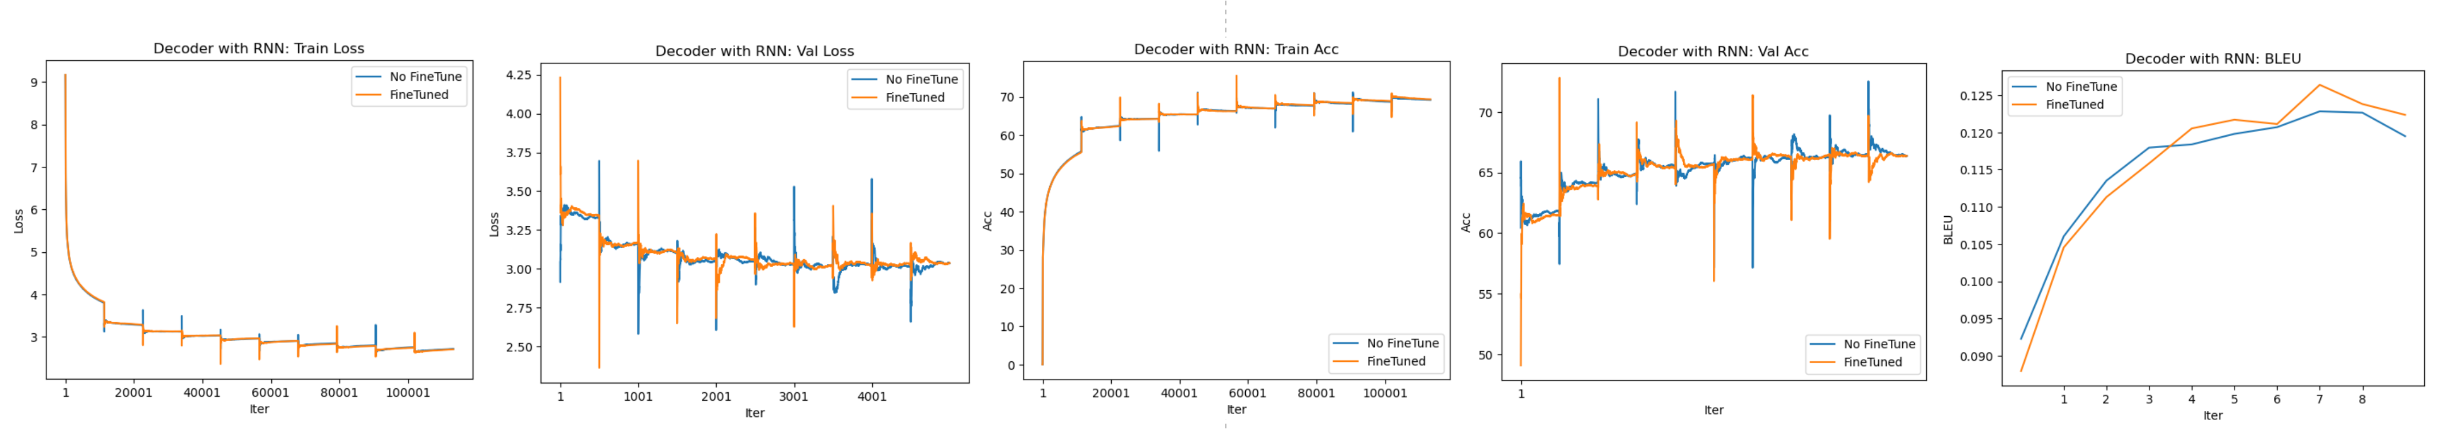  

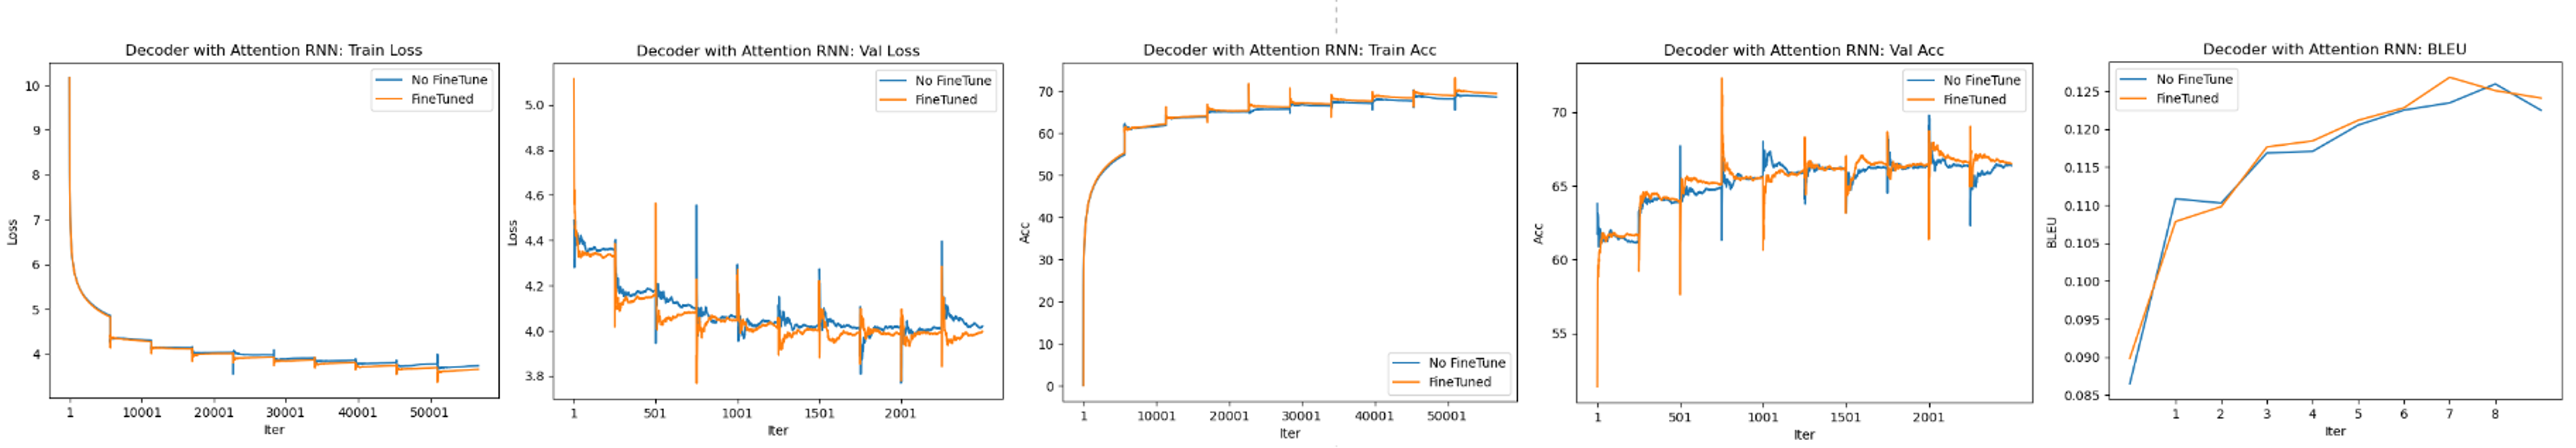  

<b>Observations:</b>  
1. Decoder with RNN:
   * Loss curves and accuracy curves with encoder and fine-tuned encoder are close to each other. The performance of the model is not decisively affected by enabling the fine-tuning on the pretrained encoder. One reason could be that we are using a small dataset and a quite small batch size. Although using transfer learning means that we need way less data than training from scratch, we still need enough data to cover the diversity.
   * Fine-tuned encoder has a higher BLEU score than the non-tuned encoder. However, it is only higher by around 0.5. This would not be acknowledged as a significant improvement, given the BLEU score is already low enough.
2. Decoder with RNN and Attention:
   * Similar to decoder with RNN only, fine-tuning does not bring in huge improvements in the model performance. However, the improvement is larger than with only RNN. This could be because we are using a larger batch size, and therefore more divergence is covered in the training and fine-tuning.
3. An overfitting seems to happen to the  4 models we tested in this section, after epoch 7. But we are not going to decrease the max epoch amount for final models or later parameter tuning, since the dataset here is small.
4. All the loss curves have a similar shape within every epoch: decrease, climb up aggressively, then temps to stabilize with a gentle upward trend. This is because the model finds a local minima, then pushes to the next optimal as the learning continues.
5. In conclusion, since the dataset we used here is of a small size, the divergence of the data is not fully exposed to the encoder. Therefore, the fine-tuning does not introduce significant changes, but only improvements at an extremely small rate. We will use fine-tuning on the final models to verify if greater changes can be made.  

### 2.5 Embed Dimension

Decoder with RNN
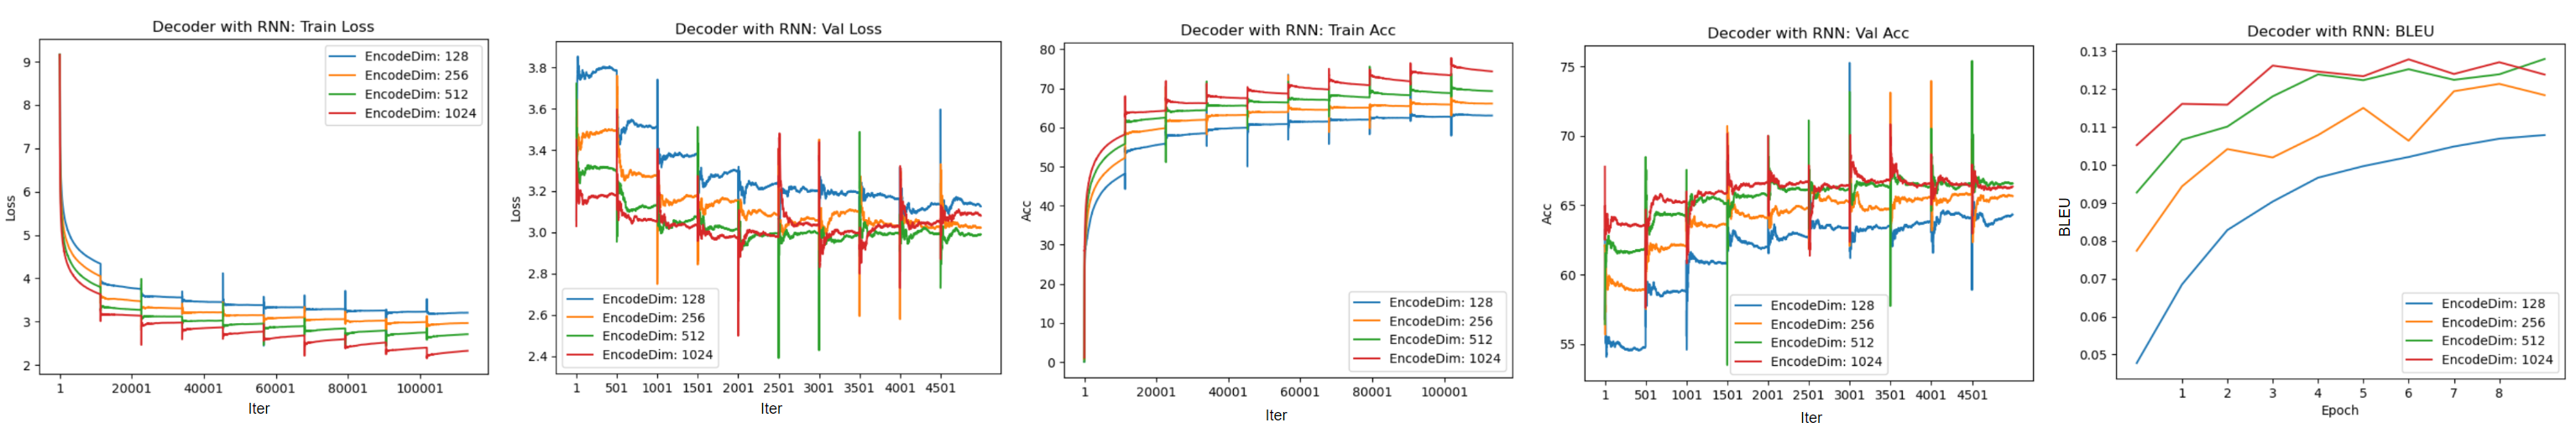

Decoder with RNN and Attention
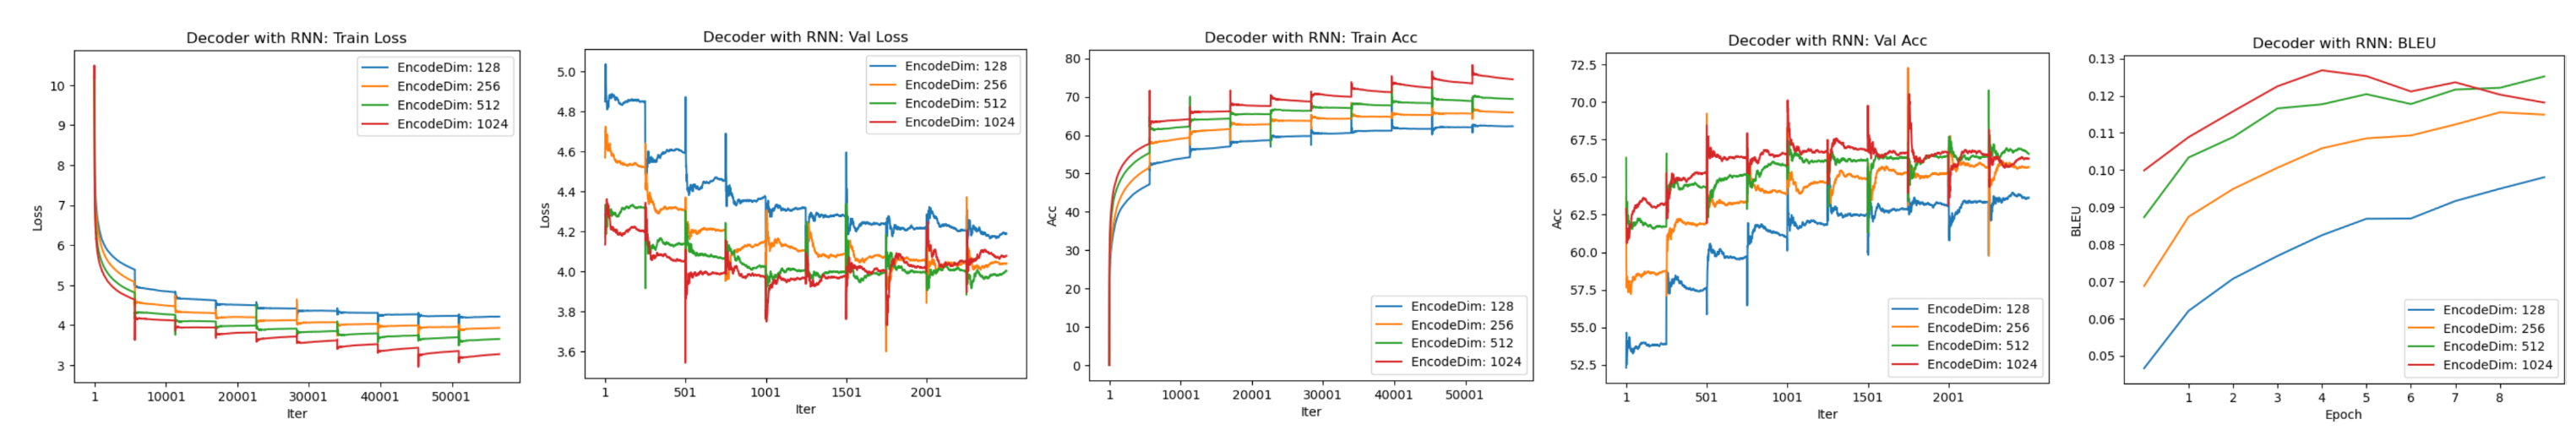  

<b>Observations:</b>  
1. For decoders RNN and attention with RNN, small embed and decode dimensions can result in low quality learning results. When the dimension is set to 128, the models have the worst performances, with the highest loss and lowest accuracy on both the train set and the validation set. As analyzed at the head of this section, the small dimension value corresponds to low complexity and low expressive capacity of the model, that is, such a model will find it difficult to find a regression or expression for comparatively complicated relationships.
2. Before the dimension amount gets to 1024, the greater the dimension amount is, the better the model behaves. Dimension 1024 although having the best performances at the early stage of training, dimension 512 exceeds it after epoch 8 or  9. Also, due to the computation cost being way too much for the machine we used, we will not use this dimension for the final model.

### 2.6 Summary  

Decoding with RNN and with Attention RNN both have similar learning results at the first few iterations. Given the same batch size and learning rate, RNN decoder has a faster convergence compared to Attention RNN. However, the highest accuracy and BLEU scores that RNN with attention has achieved is higher than RNN only on this subset of data.  This indicates that the learning on captions, especially grammatical wise, should not only rely on the feature of the images, but also the importance of words. The attention mechanism has its advantages in this, although it can slow down the model efficiency, since there is more to learn.  

Transfer learning provides the possibility to have a promising performance without the need of much training cost and data. In this section, models with either decoder mechanism have slightly improved the learning results with fine tuning on the pretrained encoder. The improvement is not significant, but highly possible that it is limited because the subset data does not cover enough diversities. Another possibility of small improvements is the limitation of transfer learning, that is, if the source data or the task for pretrain doesn't adequately represent the target domain, this mismatch will make the model performance not ideal enough. Further investigation needs to be run to determine if this data mismatch limitation has a decisive impact in our case.  

The model complexity also has an influence on the training results. With too simple parameters and too few dimensions(neuron units), a model will find it difficult to express complicated relationships between features and to learn any complicated hypothesis. With too complex models, overfitting can easily happen in the training stage.  

## 3. Final Model  

Based on the analysis above, we will run two models for conclusion:  
1. Fine-tuned encoder, decoder with RNN, Batch size 16, embed and decode dimension 512, with Adam optimizer and gradient clip threshold set to 8;
2. Fine-tuned encoder, decoder with RNN and Attention, Batch size 32, embed and decode dimension 512, with Adam optimizer and gradient clip threshold set to 8.

The gradient threshold was increased from 5 to 8 to allow more aggressive updates on the model now that the dataset is much larger. Accordingly, we will double the best batch size we have chosen from Section 3, to prevent small batches updating the model too often. This also helps to avoid the risk that too little diversity is exposed to the model per step, since now the data amount is greater.  

The original plan is to run each model for 15 epochs with early stopping and weight decaying based on contiguous epochs that have no improvements from the best performing scores during the training process. Due to the limitation of time and computation source, we only run limited epochs.   

### 3.1 Decoder with RNN  

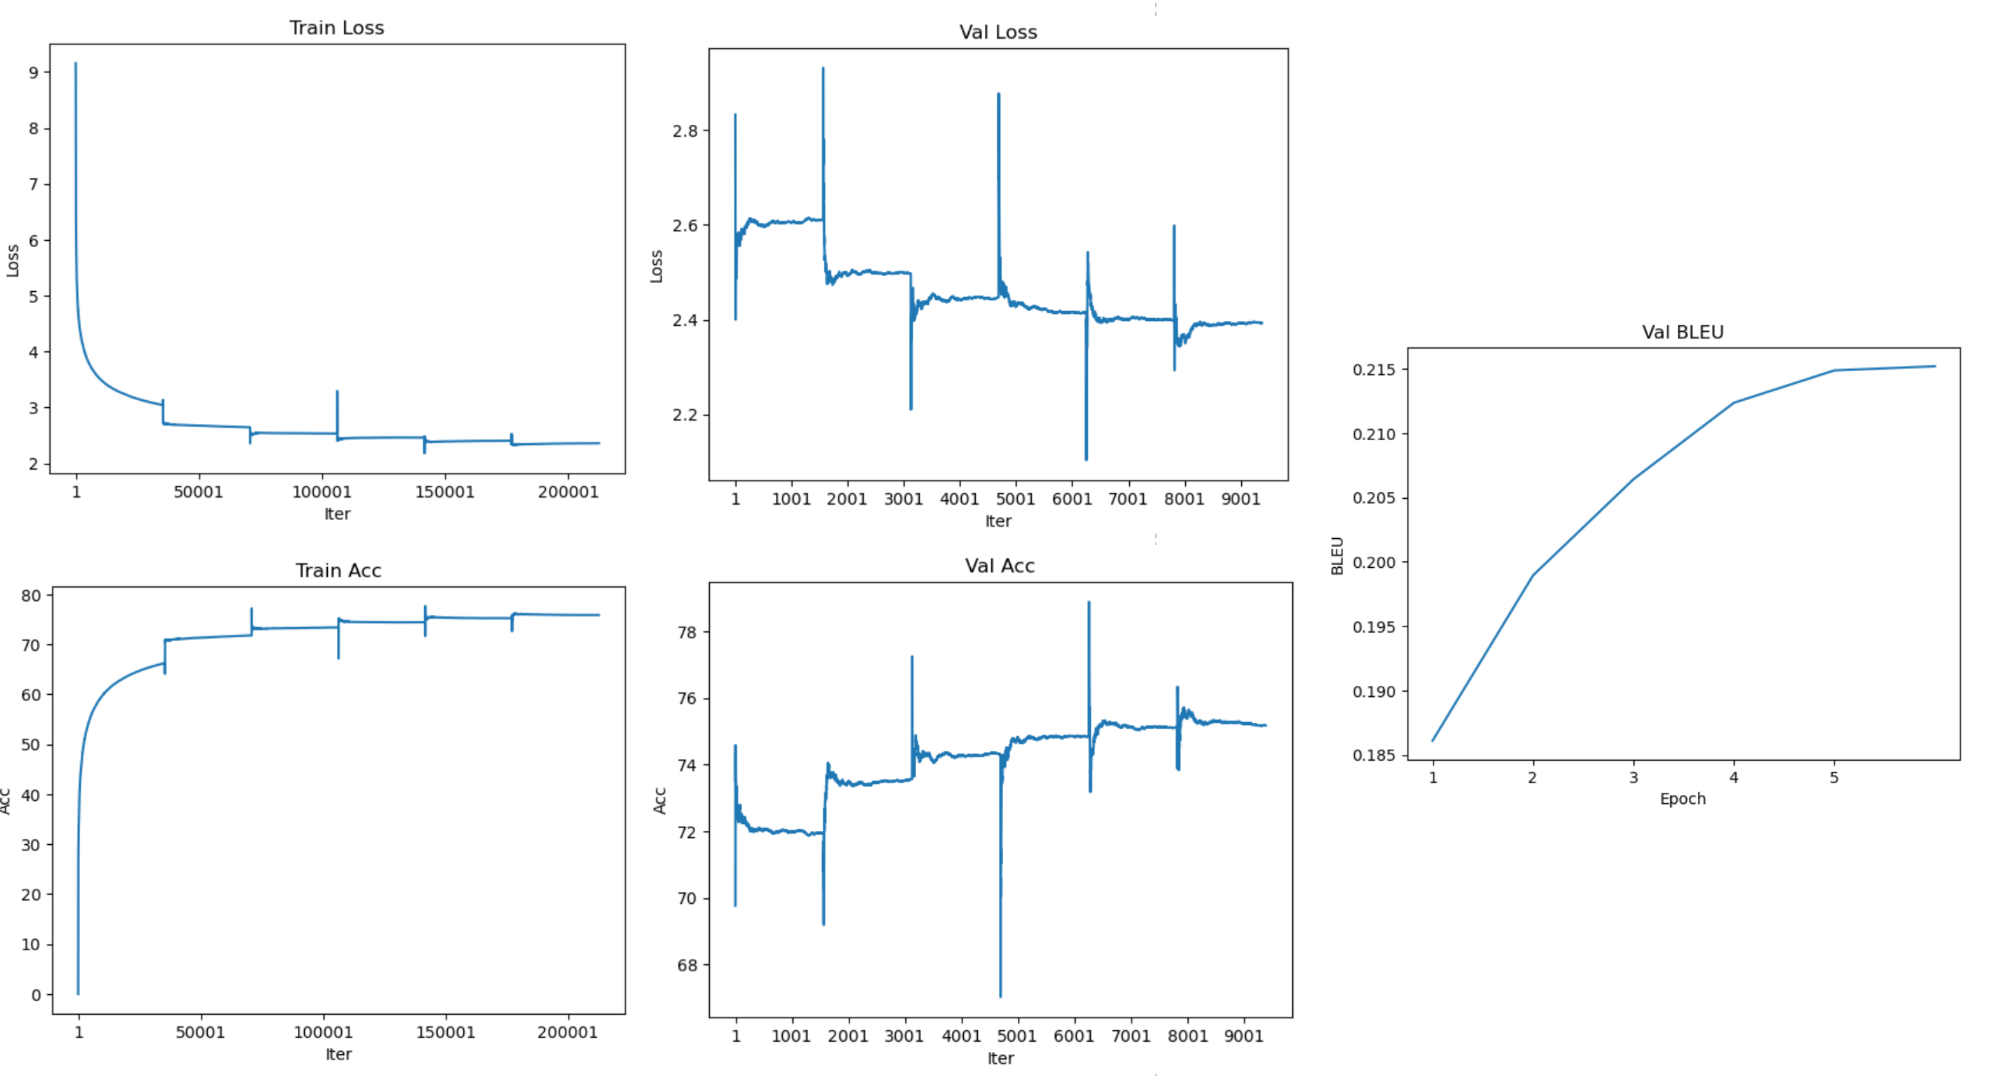

As can seen from the diagrams above, the model has not finished convergence, more epochs need to be run to get out of the current underfitting scenario. In total, 6 epochs are run. The best performance is with the 6th epoch. The scores on the validation set is: <b>LOSS - 2.393, TOP-5 ACCURACY - 75.175, BLEU-4 - 0.21520169228251065</b>. BLEU score on the test set is: <b>0.269535</b>.

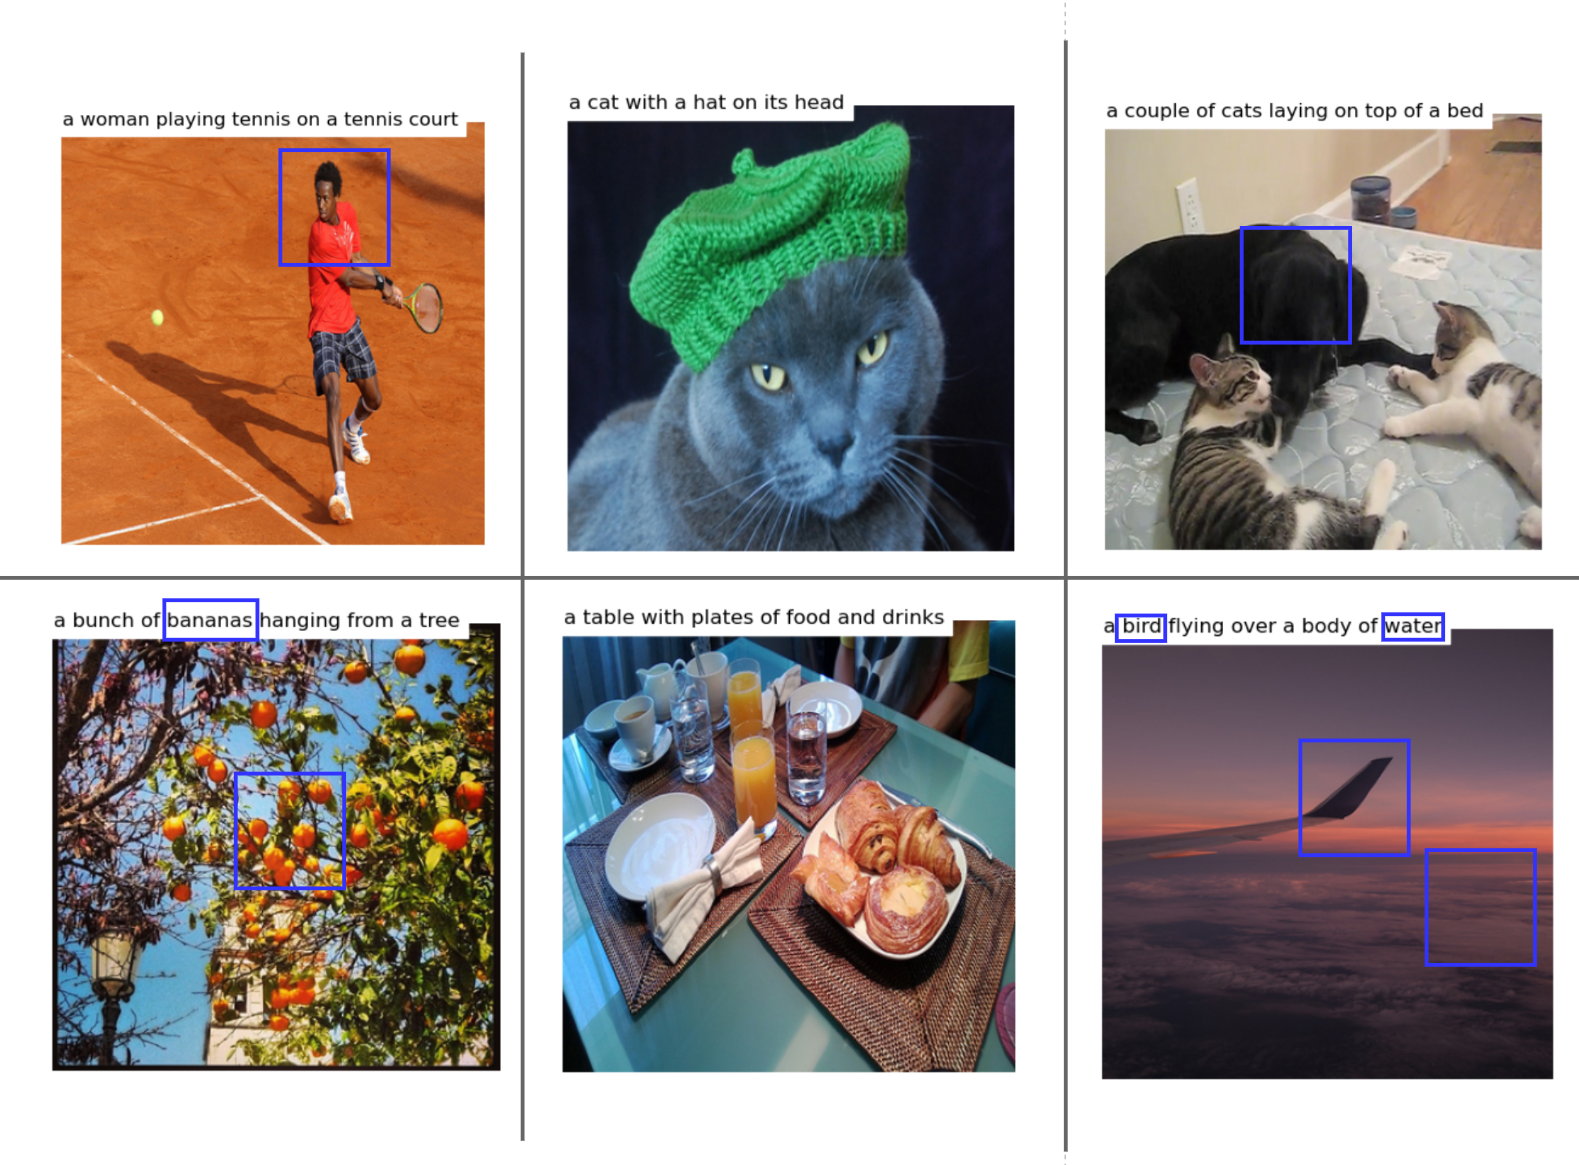

### 3.2 Decoder with RNN and Attention
Most of the training log data got lost due to interruption in the process, so no training log curves could be drawn. As far as remembered, the model keeps converging in the first 5 epochs. It reaches higher accuracy scores and higher BLEU scores within a shorter time compared to decoding with RNN only. However, the loss is higher in this model compared to Section 4.1. Therefore, it is safe to assume that small batch sizes do allow faster convergence, and learning on attention could reduce the model efficiency.  

We run in total 7 epochs on the full dataset. The best performance is on the 7th epoch. The scores achieved on the validation set for epoch 7 is: <b>LOSS - 3.291, TOP-5 ACCURACY - 76.559, BLEU-4 - 0.23356710818685755</b>.  
The BLEU score on the test set is: <b>0.29279</b>.

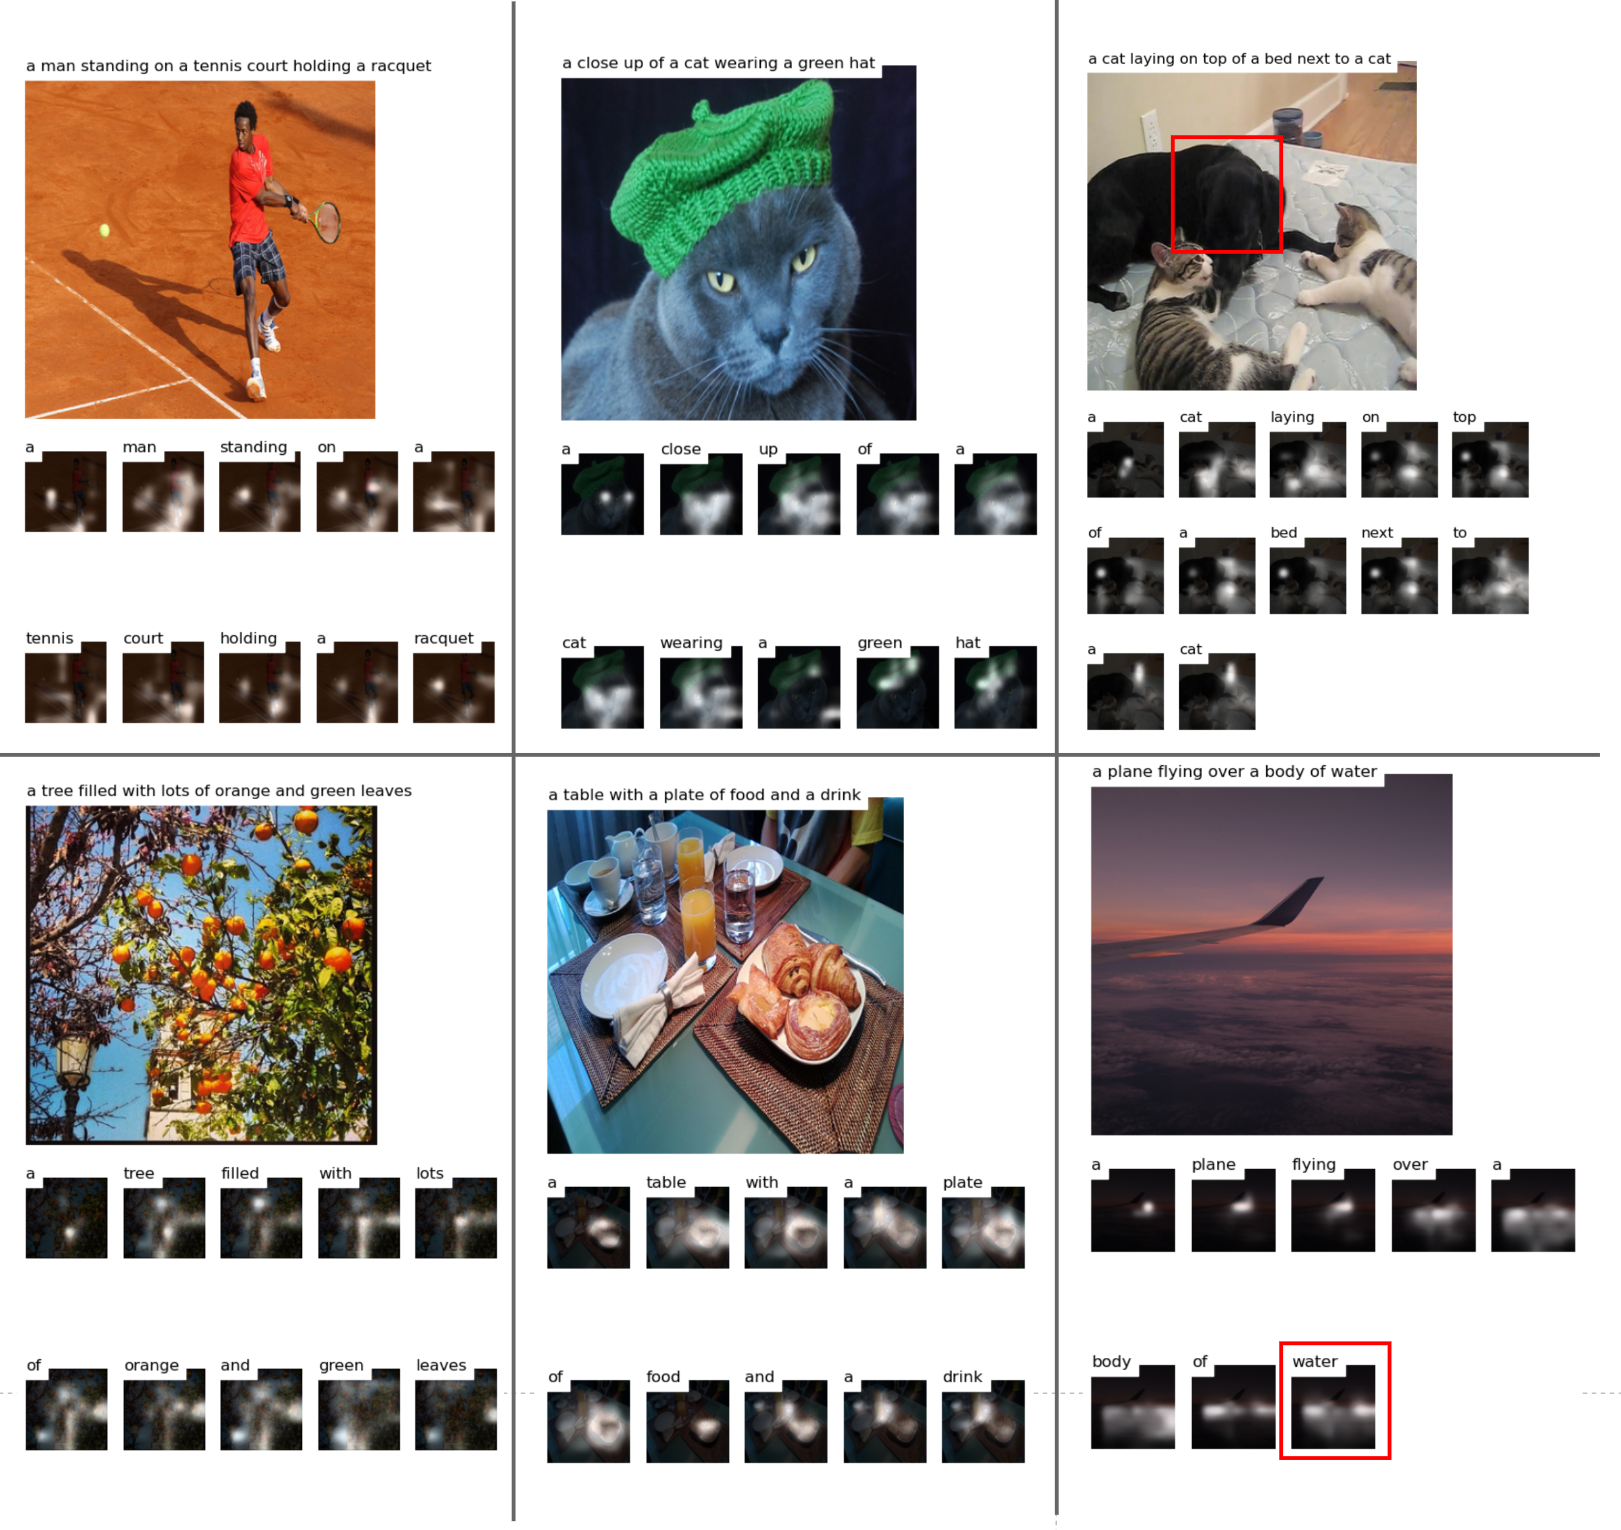


### 3.3 Summary  

As the BLEU scores have continuos increasing trend, we could safely say that the model is underfitting. It can be predicted that better semantic captions can be generated if we keep traing the model for more epochs.   

For the image-caption diagrams above, the rectangles circle out typical errors on features and on texts. Decoding with RNN has lower accuracy and BLEU scores. This phenonmenon can also be reflected from the diagrams that many objects are misclassified.   
Attention RNN has more correct classification over a diversity of object types. Wrong classification still happens when an object type is less represented in the training data, for example, the "cloud" is recognized as "water".   

One typical limitation with RNN decoder is that the generated captions are missing levels of details. For example, the image with a cat wearing a hat. RNN decoder could express the contents of the image, but Attention RNN can fill in details such as "close up" and the color of the hat. The AttentionRNN decoder can generate synthetic captions with details, but not handle the order of phrases, preposition words, etc. It is worth trying some other attention calculation ways, or consider transformers for improvements. Both two decoders have difficulties to detect and describe all objects in an image, especially when multiple object types exist. An example is the image with cats and a dog. No desciption for the dog is generated by neither of the decoders. This can also be because of the encoder fail to detect the object, or just the priority of words is not well learnt by the decoders. 

---

<i>Below are just some code snippets we use for training.</i>

---

In [4]:
# Loss function
criterion = nn.CrossEntropyLoss().to(cfg['device'])

In [5]:
def custom_dataloader(batch_size):
    cfg['batch_size'] = batch_size
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    train_loader = torch.utils.data.DataLoader(
        CaptionDataset(cfg['data_folder'], cfg['data_name'], 'TRAIN', transform=transforms.Compose([normalize])),
        batch_size=cfg['batch_size'], shuffle=True, num_workers=cfg['workers'], pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        CaptionDataset(cfg['data_folder'], cfg['data_name'], 'VAL', transform=transforms.Compose([normalize])),
        batch_size=cfg['batch_size'], shuffle=True, num_workers=cfg['workers'], pin_memory=True)
    return train_loader, val_loader

In [6]:
train_loss_for_batch_sizes = []
train_acc_for_batch_sizes = []
val_loss_for_batch_sizes = []
val_acc_for_batch_sizes = []
blue_for_batch_sizes = []

In [ ]:
# prepare data loader
train_loader, val_loader = custom_dataloader(16)

train_loss = []
train_acc = []
val_loss = []
val_acc = []
val_blue = []

if cfg['checkpoint'] is None:
    encoder = Encoder()
    encoder.fine_tune(cfg['fine_tune_encoder'])
    encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                         lr=cfg['encoder_lr']) if cfg['fine_tune_encoder'] else None
    if not cfg['attention']:
        decoder = DecoderWithRNN(cfg)
    else:
        decoder = DecoderWithAttention(cfg)
    decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                         lr=cfg['decoder_lr'])
else:
    checkpoint = torch.load(cfg['checkpoint'])
    cfg['start_epoch'] = checkpoint['epoch'] + 1
    cfg['epochs_since_improvement'] = checkpoint['epochs_since_improvement']
    cfg['best_bleu4'] = checkpoint['bleu-4']
    encoder = checkpoint['encoder']
    encoder_optimizer = checkpoint['encoder_optimizer']
    decoder = checkpoint['decoder']
    decoder_optimizer = checkpoint['decoder_optimizer']
    if cfg['fine_tune_encoder'] is True and encoder_optimizer is None:
        encoder.fine_tune(cfg['fine_tune_encoder'])
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=cfg['encoder_lr'])
# Move to GPU, if available
decoder = decoder.to(cfg['device'])
encoder = encoder.to(cfg['device'])

# Epochs
for epoch in range(cfg['start_epoch'], cfg['epochs']):

    # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
    if cfg['epochs_since_improvement'] == 6:
        break
    if cfg['epochs_since_improvement'] > 0 and cfg['epochs_since_improvement'] % 3 == 0:
        adjust_learning_rate(decoder_optimizer, 0.8)
        if cfg['fine_tune_encoder']:
            adjust_learning_rate(encoder_optimizer, 0.8)

    # One epoch's training
    epoch_loss, epoch_acc = train(train_loader=train_loader,
          encoder=encoder,
          decoder=decoder,
          criterion=criterion,
          encoder_optimizer=encoder_optimizer,
          decoder_optimizer=decoder_optimizer,
          epoch=epoch,
          cfg=cfg)
    train_loss += epoch_loss
    train_acc += epoch_acc
    print(len(train_loss))
    print(len(train_acc))
    
    # One epoch's validation
    recent_bleu4, val_epoch_loss, val_epoch_acc = validate(val_loader=val_loader,
                            encoder=encoder,
                            decoder=decoder,
                            criterion=criterion,
                            word_map=word_map,
                            cfg=cfg)
    val_loss += val_epoch_loss
    val_acc += val_epoch_acc
    val_blue.append(recent_bleu4)
    print(len(val_loss))
    print(len(val_acc))
    
    # Check if there was an improvement
    is_best = recent_bleu4 > cfg['best_bleu4']
    cfg['best_bleu4'] = max(recent_bleu4, cfg['best_bleu4'])
    if not is_best:
        cfg['epochs_since_improvement'] += 1
        print("\nEpochs since last improvement: %d\n" % (cfg['epochs_since_improvement'],))
    else:
        cfg['epochs_since_improvement'] = 0

    # Save checkpoint
    save_checkpoint(cfg['data_name'], epoch, cfg['epochs_since_improvement'], encoder, decoder, encoder_optimizer,
                    decoder_optimizer, recent_bleu4, is_best, "AttentionRNN_batchsize16")

In [ ]:
x = [i for i in range(1, len(val_blue)+1)]

plt.figure()
plt.xticks(np.arange(1,len(val_blue),step=1))

plt.plot(x, val_blue, linestyle='-')

plt.xlabel('Epoch')
plt.ylabel("BLEU")
plt.title("Val BLEU")

## 4. Conclusion  

On our final model, we run RNN decoder with 6 epochs and Attention RNN decoder with 7 epochs on the full data set.   
With RNN decoder, the scores on the validation set is: <b>LOSS - 2.393, TOP-5 ACCURACY - 75.175, BLEU-4 - 0.21520169228251065</b>. BLEU score on the test set is: <b>0.269535</b>.
With Attention RNN decoder, the scores on the validation set is: <b>LOSS - 3.291, TOP-5 ACCURACY - 76.559, BLEU-4 - 0.23356710818685755</b>. The BLEU score on the test set is: <b>0.29279</b>.  

The BLEU scores have continuos increasing trend throughout the epochs we run, therefore we could safely say that the model is underfitting. It can be predicted that better semantic captions can be generated if we keep traing the model for more epochs.  

For tuning parameters, we first run batches of experiments on a subset of data which has much smaller amount of smaple points.   
Given the same batch size and learning rate, RNN decoder has a faster convergence compared to Attention RNN. However, the highest accuracy and BLEU scores that RNN with attention has achieved is higher than RNN only on this subset of data. This indicates that the learning on captions, especially grammatical wise, should not only rely on the feature of the images, but also the importance of words. The attention mechanism has its advantages in this, although it can slow down the model efficiency, since there is more to learn.  
The model complexity also has an influence on the training results. With too simple parameters and too few dimensions(neuron units), a model will find it difficult to express complicated relationships between features and to learn any complicated hypothesis. With too complex models, overfitting can easily happen in the training stage.r".

One typical limitation with RNN decoder is that the generated captions are missing levels of details. For example, the image with a cat wearing a hat. RNN decoder could express the contents of the image, but Attention RNN can fill in details such as "close up" and the color of the hat. The AttentionRNN decoder can generate synthetic captions with details, but not handle the order of phrases, preposition words, etc. It is worth trying some other attention calculation ways, or consider transformers for improvements. Both two decoders have difficulties to detect and describe all objects in an image, especially when multiple object types exist. An example is the image with cats and a dog. No desciption for the dog is generated by neither of the decoders. This can also be because of the encoder fail to detect the object, or just the priority of words is not well learnt by the decoders.